### Configuration

In [1]:
import sqlite3
import pandas as pd
from pyspark.sql import SparkSession
#from pyspark.ml.feature import StandardScaler
from sklearn.preprocessing import StandardScaler
from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.clustering import KMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from pyspark.sql.types import *
import sys
import os
import matplotlib.pyplot as plt
import psutil
import random
import numpy as np
import seaborn as sns
from scipy.spatial import Voronoi, voronoi_plot_2d



In [2]:
spark = SparkSession.builder \
    .appName("suggestify") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "4") \
    .config("spark.executor.instances", "1") \
    .getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 200)
spark.conf.set("spark.default.parallelism", 200)

your 131072x1 screen size is bogus. expect trouble
25/04/02 00:13:50 WARN Utils: Your hostname, SS22-30061A7600 resolves to a loopback address: 127.0.1.1; using 192.168.100.221 instead (on interface eth0)
25/04/02 00:13:50 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/02 00:13:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
venv_path = os.path.dirname(os.path.dirname(sys.executable))

#conseguir direccion del proyecto, donde esta la bd
project_path = os.path.dirname(venv_path)

In [4]:
#sqlite_conn = sqlite3.connect(project_path+"/extracted.db") #clase
sqlite_conn = sqlite3.connect(venv_path+"/extracted.db") #portatil

cursor = sqlite_conn.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in SQLite:", tables)

df = pd.read_sql("SELECT * FROM extracted", sqlite_conn)

sqlite_conn.close()

df.head()

Tables in SQLite: [('extracted',)]


,track_uri,track_name,artist_name,artist_uri,album_name,album_uri,duration_ms,danceability,energy,key,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,fduration_ms,time_signature
0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,spotify:artist:2wIVse2owClT7go1WT98tk,The Cookbook,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,226863,0.904,0.813,4,...,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...,226864,4
1,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,spotify:artist:26dSoYclwsYLMAKD3tpOr4,In The Zone,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,198800,0.774,0.838,5,...,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...,198800,4
2,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Dangerously In Love (Alben für die Ewigkeit),spotify:album:25hVFAxTlDvXbx2X2QkUkE,235933,0.664,0.759,2,...,0.0598,0.701,99.252,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...,235933,4
3,spotify:track:1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,spotify:artist:31TPClRtHm23RisEBtV3X7,Justified,spotify:album:6QPkyl04rXwTGlGlcYaRoW,267266,0.892,0.714,4,...,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...,267267,4
4,spotify:track:1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,spotify:artist:5EvFsr3kj42KNv97ZEnqij,Hot Shot,spotify:album:6NmFmPX56pcLBOFMhIiKvF,227600,0.853,0.606,0,...,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...,227600,4


In [5]:
df.shape

(2261644, 25)

In [6]:
print(df.info())  # Check column types
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2261644 entries, 0 to 2261643
Data columns (total 25 columns):
 #   Column            Dtype  
---  ------            -----  
 0   track_uri         object 
 1   track_name        object 
 2   artist_name       object 
 3   artist_uri        object 
 4   album_name        object 
 5   album_uri         object 
 6   duration_ms       int64  
 7   danceability      float64
 8   energy            float64
 9   key               int64  
 10  loudness          float64
 11  mode              int64  
 12  speechiness       float64
 13  acousticness      float64
 14  instrumentalness  float64
 15  liveness          float64
 16  valence           float64
 17  tempo             float64
 18  type              object 
 19  id                object 
 20  uri               object 
 21  track_href        object 
 22  analysis_url      object 
 23  fduration_ms      int64  
 24  time_signature    int64  
dtypes: float64(9), int64(5), object(11)
memory us

In [7]:
df.columns

Index(['track_uri', 'track_name', 'artist_name', 'artist_uri', 'album_name',
       'album_uri', 'duration_ms', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 'analysis_url',
       'fduration_ms', 'time_signature'],
      dtype='object')

In [8]:
df['track_id'] = df['track_uri'].astype('category').cat.codes
df['artist_id'] = df['artist_name'].astype('category').cat.codes
df['album_id'] = df['album_name'].astype('category').cat.codes


In [ ]:
df = df[["track_id", "track_name", "artist_name", "artist_id", "album_name", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_others = df[["track_id", "track_uri", "artist_uri", "album_uri", "type", "uri", "id", "fduration_ms", "track_href", "analysis_url"]]

We can now clean the data, and separate the numerical data from the categorical, using the id in both as identification

In [ ]:
df_numerical = df[["track_id", "artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]]

df_categorical = df[["track_id", "track_name", "artist_name", "album_name"]]

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numerical.drop('track_id', axis=1))


In [12]:
X_rank = np.linalg.matrix_rank(df_scaled)
print('Rank of X_train:', X_rank)
K_linspace = np.linspace(1, 0.75 * X_rank, 10, dtype=int)
Ks = np.unique( K_linspace)

RMSE_train = np.arange(len(Ks))

Ks 

Rank of X_train: 15


array([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11])

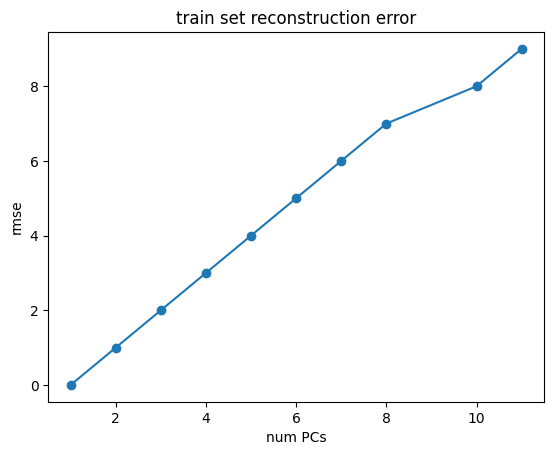

In [ ]:
import matplotlib.pyplot as plt

# Fraction of variance explained
pca = PCA(n_components=X_rank)
X_transformed = pca.fit_transform(df_numerical)
evals = pca.explained_variance_  # eigenvalues in descending order

fraction_var = np.cumsum(evals[0:50] / np.sum(evals))

fig, ax = plt.subplots()
xs = Ks
ys = RMSE_train
plt.title("train set reconstruction error")
plt.xlabel("num PCs")
plt.ylabel("rmse")
ax.plot(xs, ys, marker="o")
plt.show()

In [14]:
#apply PCA (sin std)
pca = PCA(n_components=4) 
pca_result = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'])

In [15]:
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

Explained Variance Ratio: [0.21213641 0.09000128 0.08149928 0.0790624 ]


-----------------------------------------------
Percentage of explained variance per component:
-----------------------------------------------
[0.21213641 0.09000128 0.08149928 0.0790624 ]


Text(0, 0.5, 'Explained variance')

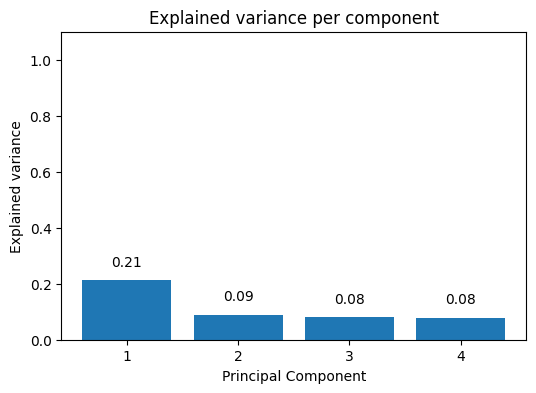

In [ ]:
print('-----------------------------------------------')
print('Percentage of explained variance per component:')
print('-----------------------------------------------')
print(pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca.n_components_) + 1,
    height = pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Explained variance per component')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained variance')

In [17]:
print('-------------------------------------------------------------------------')
print('Explainability per variable for each the first four principal components:')
print('-------------------------------------------------------------------------')
print(pca.components_)

-------------------------------------------------------------------------
Explainability per variable for each the first four principal components:
-------------------------------------------------------------------------
[[ 0.00901523  0.00381833 -0.05510024  0.30926595  0.48267539  0.04157388
   0.47671251 -0.04613078  0.11887926 -0.42754624 -0.26741997  0.08770411
   0.32384816  0.16428789  0.17068754]
 [-0.05074011 -0.04794546 -0.41356834  0.45694892 -0.27056207 -0.03998625
  -0.14168381  0.13600707  0.16671057  0.30180714 -0.25371241 -0.22352689
   0.44859318 -0.25967007  0.00565801]
 [ 0.00624642  0.00223088 -0.1420878  -0.2472774   0.02945022 -0.24222589
   0.02060202  0.32278696  0.42836583  0.10206146 -0.31556001  0.62054381
  -0.08421189 -0.02940853 -0.26065556]
 [ 0.11963452  0.04933884 -0.12029505 -0.09826226  0.02727599 -0.52277298
   0.11301086  0.58409683 -0.45532361 -0.05279341 -0.02901751 -0.25425632
   0.03301793  0.23327026  0.00710927]]


In [18]:
print('--------------------------------------------------------------')
print('Explainability per variable for the first PC:')
print('--------------------------------------------------------------')
# Obtener los loadings del primer componente
pc1_loadings = pca.components_[0]

# Nombres de las variables originales
variables = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]



# Crear un DataFrame con los resultados
df_loadings = pd.DataFrame({
    'Variable': variables,
    'Explainability per variable PC1': pc1_loadings
})

df_loadings

--------------------------------------------------------------
Explainability per variable for the first PC:
--------------------------------------------------------------


,Variable,Explainability per variable PC1
0,artist_id,0.009015
1,album_id,0.003818
2,duration_ms,-0.055100
3,danceability,0.309266
4,energy,0.482675
5,key,0.041574
6,loudness,0.476713
7,mode,-0.046131
8,speechiness,0.118879
9,acousticness,-0.427546


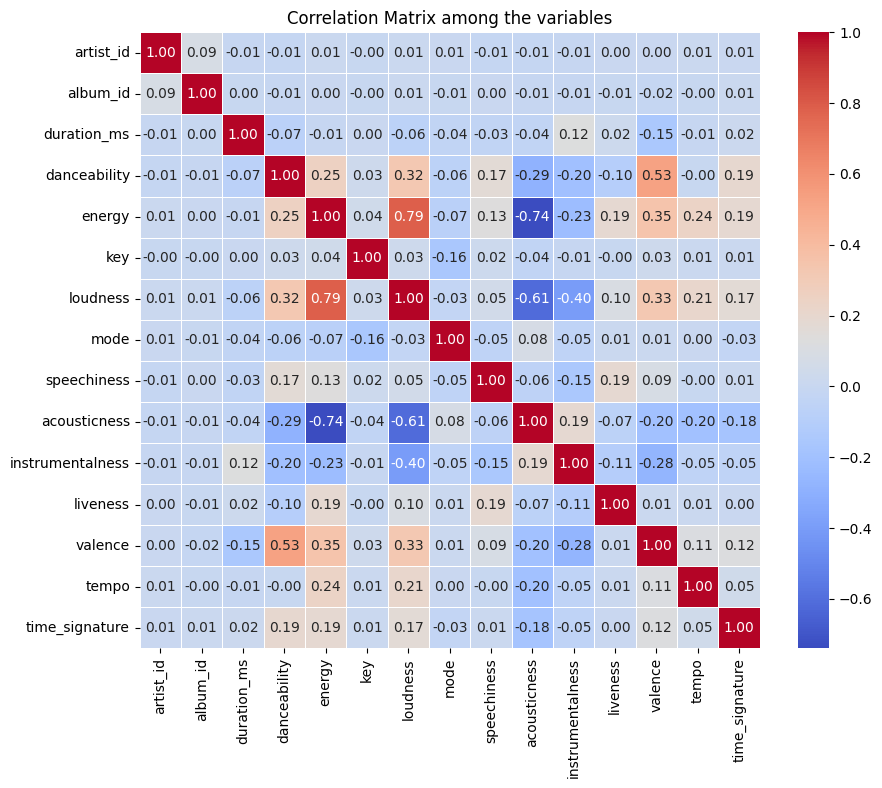

In [ ]:
# Calcular la matriz de correlación
corr_matrix = df_numerical[["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]].corr()

# Crear un gráfico de calor para visualizar la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix among the variables")
plt.show()

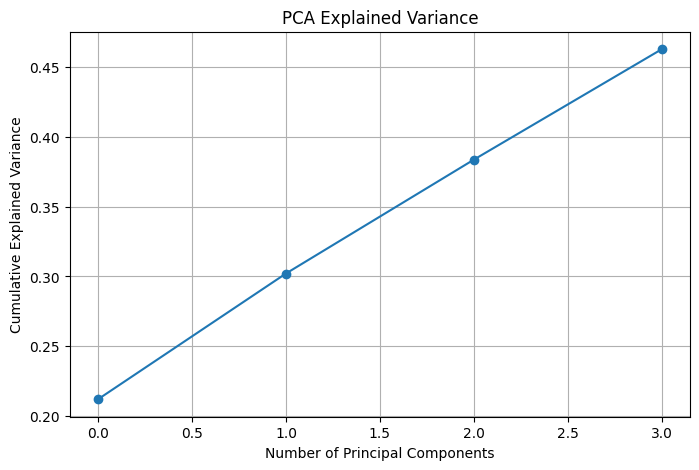

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Plot variance explained
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

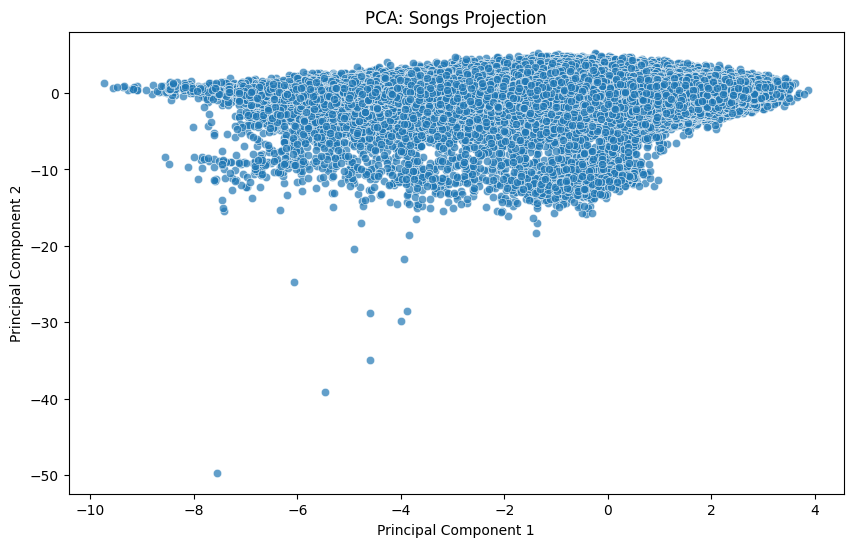

In [21]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: Songs Projection')
plt.show()

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-transformed data (PC1, PC2)
X = df_pca[['PC1', 'PC2']]

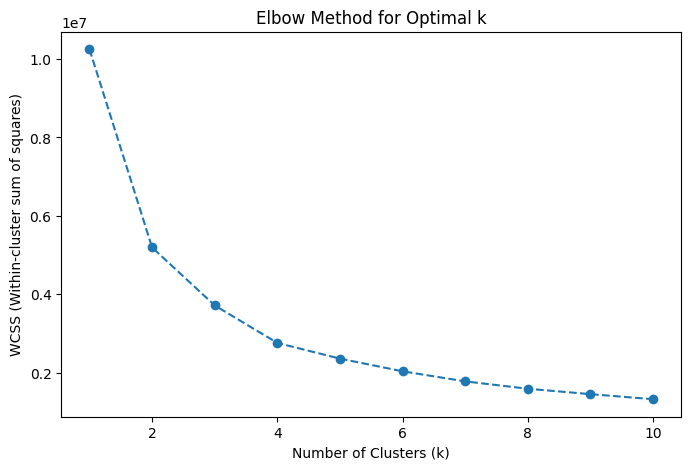

In [25]:
wcss = []  # Within-cluster sum of squares

for k in range(1, 11):  # Try k values from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-cluster sum of squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

In [28]:
optimal_k = 4   # Change this based on elbow method results

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt

N = 100000
df_scaled_subset = df_scaled[:N]

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init='random'
)
tsne_results = tsne.fit_transform(df_scaled_subset)

# Evaluation loop
silhouette_scores = []
ch_scores = []
k_values = range(2, 15)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(tsne_results)
    
    sil_score = silhouette_score(tsne_results, labels)
    ch_score = calinski_harabasz_score(tsne_results, labels)
    
    silhouette_scores.append(sil_score)
    ch_scores.append(ch_score)
    
    print(f"k={k}: Silhouette={sil_score:.4f}, CH Score={ch_score:.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (t-SNE)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, ch_scores, marker='o', color='orange')
plt.title("Calinski-Harabasz Score vs. Number of Clusters (t-SNE)")
plt.xlabel("k")
plt.ylabel("CH Score")
plt.grid(True)

plt.tight_layout()
plt.show()

k=2: Silhouette=0.3812, CH Score=70830.14
k=3: Silhouette=0.3449, CH Score=68758.97
k=4: Silhouette=0.3651, CH Score=86256.37
k=5: Silhouette=0.3518, CH Score=88668.32
k=6: Silhouette=0.3508, CH Score=89739.35


KeyboardInterrupt: 

In [29]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(X)

# Centroids
centroids = kmeans.cluster_centers_

/home/noraibarguren/volumen/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


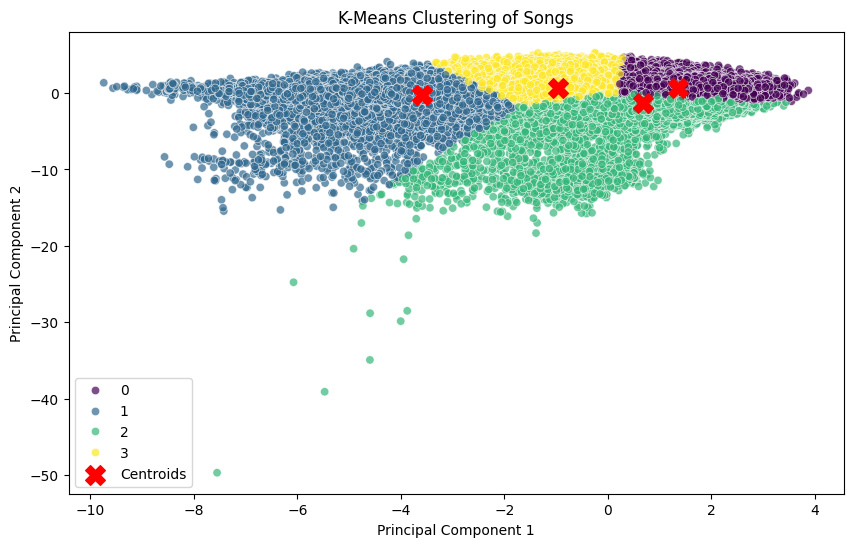

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df_pca['Cluster'], palette='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Songs')
plt.legend()
plt.show()

In [31]:
# Show 10 random songs per cluster
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df.loc[df_pca['Cluster'] == i, ['track_name', 'artist_name']].sample(10))



Cluster 0:
                      track_name                 artist_name
1749162                Bombocado                 Art Popular
871734           In The Highways              The Cox Family
945338                Todo De Mi              Trio Mi Amorch
675965       Mil Formas de Vivir                       Tempo
57002    Tonight It's Goin' Down                    Babyface
747976          De Punta a Punta  Salsa Con Clase Colombiana
1468396             Somethin2Say                    Luckyiam
622509     Oscuridad (Interlude)                 Reis Belico
1236520      El Barco Y La Marea                Maracaibo 15
2045081         Nakreeze - Attan                Jawid Sharif

Cluster 1:
                                                track_name  \
1988716                              No One Knows Who I Am   
200670                                        Besame Mucho   
152714                                     Balancing Tones   
61595                                             Heureus

In [36]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use PCA-reduced data (PC1, PC2) OR the original scaled features
X = df_scaled  # Use standardized full dataset for better representation


# Set sample size (adjust as needed)
sample_size = 10000  

# Randomly sample without replacement
df = df_numerical.sample(sample_size, random_state=42)

# Standardize the sample
df_scaled = scaler.fit_transform(df)

NameError: name 'df_numerical' is not defined

In [ ]:
# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)  # Adjust perplexity if needed
X_tsne = tsne.fit_transform(df_scaled)

# Convert to DataFrame
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['track_name'] = df['track_name']  # Optional: Add song names for reference
df_tsne['artist_name'] = df['artist_name']  # Optional: Add artist names


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of Songs')
plt.show()


In [ ]:
from sklearn.cluster import KMeans

# Apply K-Means on t-SNE output
kmeans_tsne = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_tsne['Cluster'] = kmeans_tsne.fit_predict(X_tsne)

# Plot t-SNE with Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_tsne['TSNE1'], y=df_tsne['TSNE2'], hue=df_tsne['Cluster'], palette='viridis', alpha=0.7)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization with K-Means Clusters')
plt.legend(title='Cluster')
plt.show()


In [ ]:
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    print(df_tsne[df_tsne['Cluster'] == i][['song_name', 'artist_name']].sample(10))

# Nuestros

### TSNE

In [ ]:
#KMeans with k=10
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster_pca'] = kmeans.fit_predict(df_pca)
df.head()

/tmp/ipykernel_22552/609531118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['cluster_pca'] = kmeans.fit_predict(df_pca)


,track_name,artist_name,artist_id,album_name,album_id,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,cluster_pca
track_id,,,,,,,,,,,,,,,,,,,
143810,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,171591,The Cookbook,469633,226863,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,4,2
1827850,Toxic,Britney Spears,35098,In The Zone,232630,198800,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,4,2
154482,Crazy In Love,Beyoncé,27199,Dangerously In Love (Alben für die Ewigkeit),119263,235933,0.664,0.759,2,-6.583,0,0.2090,0.00238,0.000000,0.0598,0.701,99.252,4,2
341116,Rock Your Body,Justin Timberlake,130144,Justified,249622,267266,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,4,2
516741,It Wasn't Me,Shaggy,221410,Hot Shot,216563,227600,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,4,2


In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

N = 100000
df_scaled_subset = df_scaled[:N]

tsne = TSNE(
    n_components=2,
    perplexity=30,
    random_state=42,
    init='random'
)
tsne_results = tsne.fit_transform(df_scaled_subset)

kmeans_tsne = KMeans(n_clusters=7, random_state=42)
tsne_clusters = kmeans_tsne.fit_predict(tsne_results)

df_subset = df.iloc[:N].copy()
df_subset['cluster_tsne'] = tsne_clusters

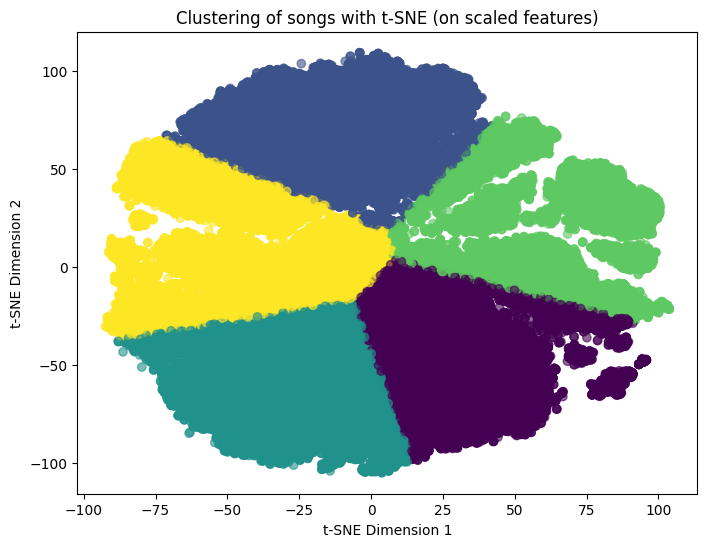

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=tsne_clusters, cmap='viridis', alpha=0.6)
plt.title('Clustering of songs with t-SNE (on scaled features)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

## 🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴
## He cambiado el tsne. Ahora lo hacemos con 100k datos (mejor, tarda 10 mins). He hecho lo de abajo para ver cuantos k estarían bien mirando sillouete (que no debe ser tan accurate para tsne), y CH score (que debe ser algo mejor). En los dos, the higher the better.
## Viendo los resultados K ahora será 7. Daba 2 (o 3, no sé que daba) por que el sample size era muy pequeño. ahora es de 100000. La celda de abajo tarda 45 minutos en correr.
## 🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴🔴

In [1]:
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

numerical_features_no_duration = ["artist_id", "album_id", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]
                

In [ ]:
def tsne(amount, features, cluster_column, ax=None):
    # Obtener índices de características
    if isinstance(features[0], str):
        feature_indices = [df_numerical.columns.get_loc(f) for f in features]
    else:
        feature_indices = features
        
    df_scaled2 = df_scaled[:amount, feature_indices]
    
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    df_tsne = tsne.fit_transform(df_scaled2)
    
    # Obtener los clusters del DataFrame original
    cluster_values = df[cluster_column].values[:amount]  # Usamos los clusters existentes
    
    # Plot - usando los clusters de df para colorear
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Verificar si los clusters son valores numéricos o colores directos
    if pd.api.types.is_numeric_dtype(df[cluster_column]):
        # Si son numéricos, usamos cmap
        scatter = ax.scatter(df_tsne[:, 0], df_tsne[:, 1], c=cluster_values, cmap='viridis', alpha=0.6)
    else:
        # Si son strings (nombres de colores), los usamos directamente
        scatter = ax.scatter(df_tsne[:, 0], df_tsne[:, 1], c=cluster_values, alpha=0.6)
    
    ax.set_title(f'{amount} samples ({cluster_column} from df)')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    
    return ax

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot in each subplot
tsne(1000, numerical_features, 'cluster_pca', ax=axes[0, 0])
tsne(1000, numerical_features_no_duration, 'cluster_pca', ax=axes[0, 1])
tsne(1000, numerical_features, 'cluster_tsne', ax=axes[1, 0])
tsne(1000, numerical_features_no_duration, 'cluster_tsne', ax=axes[1, 1])

# Add column titles
col_titles = ["With Duration", "Without Duration"]
for ax, col_title in zip(axes[0, :], col_titles):
    ax.annotate(col_title, xy=(0.5, 1.1), xycoords='axes fraction', 
                ha='center', va='center', fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

### Celdas de Voronoi

In [22]:
def plot_voronoi(amount, features, cluster_column, ax=None):
    # Obtener los datos según las características especificadas
    if isinstance(features[0], str):  # Si las características son nombres de columnas
        feature_indices = [df_numerical.columns.get_loc(f) for f in features]
        df_scaled2 = df_scaled[:amount, feature_indices]
    else:  # Si las características son índices
        df_scaled2 = df_scaled[:amount, features]
    
    # Aplicar t-SNE
    tsne = TSNE(n_components=2, perplexity=50, random_state=42)
    tsne_results = tsne.fit_transform(df_scaled2)
    
    # Obtener los clusters del DataFrame original para la cantidad de muestras seleccionada
    cluster_values = df[cluster_column].values[:amount]
    
    # Calcular los centros de los clusters existentes en el espacio t-SNE
    unique_clusters = np.unique(cluster_values)
    centers = np.array([tsne_results[cluster_values == k].mean(axis=0) for k in unique_clusters])
    
    # Calcular diagrama de Voronoi basado en los centros
    vor = Voronoi(centers)
    
    # Graficar
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Dibujar diagrama de Voronoi
    voronoi_plot_2d(vor, ax=ax, show_points=False, show_vertices=False, line_colors='orange')
    
    # Dibujar puntos coloreados por cluster con transparencia
    scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                         c=cluster_values, cmap='viridis', alpha=0.5)
    
    # Dibujar centros de los clusters
    ax.scatter(centers[:, 0], centers[:, 1], c='red', s=50, marker='x')
    
    # Añadir contornos de densidad
    for k in unique_clusters:
        cluster_points = tsne_results[cluster_values == k]
        if len(cluster_points) > 1:  # Necesitamos al menos 2 puntos para KDE
            sns.kdeplot(x=cluster_points[:, 0], y=cluster_points[:, 1], 
                        ax=ax, color='darkblue', alpha=0.3)
    
    ax.set_title(f"Voronoi para {amount} muestras ({cluster_column} preexistentes)")
    return ax

In [ ]:
# Create the 2x2 layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_voronoi(1000, numerical_features,'cluster_pca', ax=axes[0, 0])
plot_voronoi(1000, numerical_features_no_duration,'cluster_pca', ax=axes[0, 1])
plot_voronoi(1000, numerical_features,'cluster_tsne', ax=axes[1, 0])
plot_voronoi(1000, numerical_features_no_duration,'cluster_tsne', ax=axes[1, 1])

# Add column titles
fig.text(0.25, 0.92, "With Duration", ha='center', va='center', 
         fontsize=12, fontweight='bold')
fig.text(0.75, 0.92, "Without Duration", ha='center', va='center', 
         fontsize=12, fontweight='bold')

# Add row labels
fig.text(0.05, 0.75, "PCA clusters", ha='center', va='center', 
         rotation='vertical', fontsize=12, fontweight='bold')
fig.text(0.05, 0.25, "TSNE clusters", ha='center', va='center', 
         rotation='vertical', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.85, left=0.1)  # Adjust margins
plt.show()

### Recommendations to user content-based

In [ ]:
UID=1

se supone que se le recomiendan unas canciones y les da like o no o super

dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
ratings=pd.DataFrame( columns=["user", "track_id", "rating"])

In [ ]:
rating_map = {
    "dislike": -1,
    "like": 1,
    "saltar": 0,
    "super like": 2
}


while ratings.shape[0] < 20:
    num_aleatorio = random.randint(0, len(df) - 1)
    
    #info de canción
    try:
        cancion = df.loc[num_aleatorio]
        nombre_cancion = cancion['track_name']
        artista = cancion['artist_name']
    except (KeyError, IndexError):
        nombre_cancion = "Canción desconocida"
        artista = "Artista desconocido"

    
    while True:
        input_usuario = input(f"\n🎵 Canción: {nombre_cancion} - {artista}\n""Ingrese su calificación (dislike/like/saltar/super like): ").strip().lower()        
        if input_usuario in rating_map:
            rating = rating_map[input_usuario]
            break
        else:
            print("⚠️ Entrada inválida. Ingrese una opción válida: dislike, like, saltar, super like.")

    nueva_fila = [UID, num_aleatorio, rating]
    ratings.loc[ratings.shape[0]] = nueva_fila


dislike: -1
like: 1
saltar: 0
super like :2

In [ ]:
ratings

In [ ]:
!pip install umap-learn
!pip install numpy==2.1.0 --force-reinstall --upgrade

In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import umap.umap_ as umap
import os

In [ ]:
# Before generating recommendations, ensure df_scaled uses the full dataset
numerical_features = ["artist_id", "album_id", "duration_ms", "danceability", "energy", "key", "loudness", "mode", "speechiness",
                "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

# Use the full dataset for scaling and PCA
scaler = StandardScaler()
df_scaled_full = scaler.fit_transform(df_numerical[numerical_features])  # Full dataset

pca = PCA(n_components=4)
reduced_features_full = pca.fit_transform(df_scaled_full).astype(np.float32)

### He intentado lo de estas celdas pero peta

In [ ]:
def reduce_features(df, numerical_features, n_components=5):
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df[numerical_features])
    try:
        reducer = umap.UMAP(
            n_components=n_components,
            metric='cosine',
            n_neighbors=10,
            low_memory=True,
            random_state=42
        )
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)
    except Exception as e:
        reducer = PCA(n_components=n_components)
        reduced = reducer.fit_transform(df_scaled).astype(np.float32)

    return df_scaled, reduced

In [14]:
numerical_features = [
    "artist_id", "album_id", "duration_ms", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

In [10]:
df_others.head()

,track_uri,artist_uri,album_uri,type,uri,id,fduration_ms,track_href,analysis_url
track_id,,,,,,,,,
143810,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,audio_features,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,0UaMYEvWZi0ZqiDOoHU3YI,226864,https://api.spotify.com/v1/tracks/0UaMYEvWZi0Z...,https://api.spotify.com/v1/audio-analysis/0UaM...
1827850,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,audio_features,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak,198800,https://api.spotify.com/v1/tracks/6I9VzXrHxO9r...,https://api.spotify.com/v1/audio-analysis/6I9V...
154482,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,spotify:album:25hVFAxTlDvXbx2X2QkUkE,audio_features,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,0WqIKmW4BTrj3eJFmnCKMv,235933,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj...,https://api.spotify.com/v1/audio-analysis/0WqI...
341116,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,spotify:album:6QPkyl04rXwTGlGlcYaRoW,audio_features,spotify:track:1AWQoqb9bSvzTjaLralEkT,1AWQoqb9bSvzTjaLralEkT,267267,https://api.spotify.com/v1/tracks/1AWQoqb9bSvz...,https://api.spotify.com/v1/audio-analysis/1AWQ...
516741,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,spotify:album:6NmFmPX56pcLBOFMhIiKvF,audio_features,spotify:track:1lzr43nnXAijIGYnCT8M8H,1lzr43nnXAijIGYnCT8M8H,227600,https://api.spotify.com/v1/tracks/1lzr43nnXAij...,https://api.spotify.com/v1/audio-analysis/1lzr...


In [20]:
popularity= track["popularity"]
release_date_album = track["album"]["release_date"]
is_explicit = track["explicit"]
image_url = track["album"]["images"][0]["url"]

print(popularity)
print(release_date_album)
print(is_explicit)
print(image_url)

68
2005-07-04
True
https://i.scdn.co/image/ab67616d0000b273f1dfae21eaac0d24fb3dcf5a


In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Configura tus credenciales (registra una app en https://developer.spotify.com/dashboard)
client_id = "1e6d532d63fa4fbb82230cd1ffd06fc9"
client_secret = "b6281e5bb26c43d282e1a4987828366c"

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
))
# Lista para almacenar las popularidades
popularities = []

# Iterar sobre cada track en df_others
for track_uri in df_others["track_uri"]:
    try:
        track_id = track_uri.split(":")[-1]  # ¡Aquí estaba el error principal!
        # Obtener los datos del track
        track = sp.track(track_id)        
        #popularities.append(popularity)
        print(track)
            
    except Exception as e:
        #print(f"Error al obtener popularidad para {track_uri}: {str(e)}")
        print(track)
        #popularities.append(None)  # Añadir None si hay error
    break



# Mostrar el resultado
#print("\nDataFrame con popularidad añadida:")
#print(df_numerical.head())

{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/2wIVse2owClT7go1WT98tk'}, 'href': 'https://api.spotify.com/v1/artists/2wIVse2owClT7go1WT98tk', 'id': '2wIVse2owClT7go1WT98tk', 'name': 'Missy Elliott', 'type': 'artist', 'uri': 'spotify:artist:2wIVse2owClT7go1WT98tk'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'TZ', 'UG', 'AG', 'AM', 'BS', 'BB', 'BZ', 'BT', 'BW', 'BF', 'CV', '

In [ ]:
numerical_features = [
    "artist_id", "album_id", "duration_ms", "danceability", "energy", "key",
    "loudness", "mode", "speechiness", "acousticness", "instrumentalness",
    "liveness", "valence", "tempo", "time_signature"
]

df_scaled_full, reduced_features_full = reduce_features(df_numerical, numerical_features)

### Esto ya va bien

In [ ]:
# Rebuild the NearestNeighbors model with the full dataset
nn_model_full = NearestNeighbors(
    n_neighbors=50,
    metric='cosine',
    algorithm='auto',
    n_jobs=-1
).fit(reduced_features_full)


In [ ]:
def content_based_recommendation(user_ratings, df_original, df_scaled, reduced_features, 
                               top_n=10, diversity=0.7, batch_size=100):
    """
    Sistema de recomendación basado en contenido mejorado con:
    - Manejo de dataset completo
    - Mapeo correcto de índices
    - Diversidad de recomendaciones
    """
    # 1. Preparar datos y modelos
    nn_model = NearestNeighbors(n_neighbors=50, metric='cosine', algorithm='auto', n_jobs=-1).fit(reduced_features)
    df_original_reset = df_original.reset_index()
    track_id_to_idx = {track_id: idx for idx, track_id in enumerate(df_original_reset['track_id'])}
    
    # 2. Filtrar y mapear calificaciones válidas
    valid_ratings = user_ratings[user_ratings['track_id'].isin(df_original_reset['track_id'])].copy()
    if valid_ratings.empty:
        return df_original_reset.sample(min(top_n, len(df_original_reset)))
    
    valid_ratings['track_idx'] = valid_ratings['track_id'].map(track_id_to_idx)
    valid_ratings = valid_ratings.dropna(subset=['track_idx'])
    
    # 3. Configurar pesos y exclusiones
    #rating_weights = valid_ratings['rating'].map({-2: -2.0, -1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0})
    weight_map = {-1: -1.0, 0: 0.0, 1: 1.0, 2: 2.0}
    rating_weights = valid_ratings['rating'].map(weight_map)
    track_indices = valid_ratings['track_idx'].astype(int).values
    weights = rating_weights.values
    
    # 4. Búsqueda por lotes de vecinos similares
    all_scores = np.zeros(reduced_features.shape[0])
    rated_tracks = set()
    
    for i in range(0, len(track_indices), batch_size):
        batch_indices = track_indices[i:i + batch_size]
        batch_weights = weights[i:i + batch_size]
        
        distances, indices = nn_model.kneighbors(reduced_features[batch_indices])
        similarities = 1 / (1 + distances)
        weighted_scores = similarities * batch_weights[:, np.newaxis]
        
        # Actualizar puntuaciones acumuladas
        np.add.at(all_scores, indices.ravel(), weighted_scores.ravel())
        rated_tracks.update(batch_indices.tolist())
    
    # 5. Aplicar diversidad y exclusión
    noise = (np.random.rand(len(all_scores)) - 0.5) * 2 * diversity * np.mean(np.abs(all_scores))
    final_scores = all_scores * (1 - diversity) + noise
    
    # Excluir tracks ya calificados
    final_scores[list(rated_tracks)] = -np.inf
    
    # 6. Obtener mejores recomendaciones
    top_indices = np.argsort(final_scores)[-top_n:][::-1]
    valid_indices = top_indices[final_scores[top_indices] > -np.inf]
    
    if len(valid_indices) == 0:
        return pd.DataFrame(columns=df_original.columns)
    
    return df_original_reset.iloc[valid_indices].set_index('track_id')


In [ ]:
#recomendar
recommendations = content_based_recommendation(
    user_ratings=ratings,
    df_original=df,
    df_scaled=df_scaled_full,
    reduced_features=reduced_features_full,
    top_n=5,
    diversity=0.3
)

print("Recommendations:")
print(recommendations[['track_name', 'artist_name']])

# Otros

## PC3, PC4

In [ ]:
df_pca_34 = pd.DataFrame(df_pca[:, 2:], columns=['PC3', 'PC4'])

In [ ]:
#KMeans with k=10
kmeans = KMeans(n_clusters=10, random_state=42)
df['cluster'] = kmeans.fit_predict(df_pca_34)

In [ ]:
# Visualización corregida
plt.figure(figsize=(8, 6))
plt.scatter(df_pca_34['PC3'], df_pca_34['PC4'], c=df['cluster'], cmap='viridis')
plt.title('Clustering of songs with KMeans and PCA')
plt.xlabel('Principal Component 3')
plt.ylabel('Principal Component 4')
plt.colorbar(label='cluster')
plt.show()

## Spark

### Spark Dataframe

In [ ]:
#columns for clustering
feature_columns = ["danceability", "energy", "key", "loudness", "mode",
                   "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "time_signature"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_raw")
assembled_df = assembler.transform(spark_df).repartition(500).cache()
assembled_df.count()

### Intento de KMeans con Spark

In [ ]:
schema = StructType([
    StructField("track_uri", StringType(), True),
    StructField("track_name", StringType(), True),
    StructField("artist_name", StringType(), True),
    StructField("album_name", StringType(), True),
    StructField("duration_ms", IntegerType(), True),
    StructField("danceability", FloatType(), True),
    StructField("energy", FloatType(), True),
    StructField("key", IntegerType(), True),
    StructField("loudness", FloatType(), True),
    StructField("mode", IntegerType(), True),
    StructField("speechiness", FloatType(), True),
    StructField("acousticness", FloatType(), True),
    StructField("instrumentalness", FloatType(), True),
    StructField("liveness", FloatType(), True),
    StructField("valence", FloatType(), True),
    StructField("tempo", FloatType(), True),
    StructField("time_signature", IntegerType(), True)
])

spark_df = spark.createDataFrame(df, schema=schema)

spark_df.show(5)

In [ ]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features").cache()
scaled_df.count()

In [ ]:
#KMeans with 10 clusters
kmeans = KMeans(k=10, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(scaled_df)

In [ ]:
#predictions
clustered_df = model.transform(assembled_df)

In [ ]:
#plotting the clusters
pandas_df = clusters_df.select("danceability", "energy", "cluster").toPandas() #transform to pandas for plotting
plt.figure(figsize=(10, 6))
for cluster in range(10):
    cluster_data = pandas_df[pandas_df['cluster'] == cluster]
    plt.scatter(cluster_data['danceability'], cluster_data['energy'], label=f'Cluster {cluster}')

plt.title('Clustering de canciones por danceability y energy')
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.legend()
plt.show()